In [10]:
import cv2
import os
import matplotlib.pyplot as plt
from keras.models import load_model

In [11]:
refPt = []
cropping = False

In [12]:
def click_and_crop(event, x, y, flags, param):
    
    # grab references to the global variables
    global refPt, cropping
    
    # if the left mouse button was clicked, record the starting 
    # (x,y) coordinates and indicate the cropping is being performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x,y)]
        cropping = True
        print(".........a.....a.......a")
    
    # check to see if the left mouse was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x,y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x,y))
        cropping = False
        print("BAU")
        

In [13]:
def watch_webcam():
    cv2.namedWindow("preview")
    vc = cv2.VideoCapture(0)
    
    while vc.isOpened():
        _, frame = vc.read()
        img = frame
        # clone the image
        clone = img.copy()
        
        key = cv2.waitKey(100)
        cv2.imshow("preview", img)
        cv2.setMouseCallback("preview", click_and_crop)
        
        if len(refPt) == 2:
            roi = clone[refPt[0][1]:refPt[1][1],refPt[0][0]:refPt[1][0]]
            #cv2.imshow("ROI",roi)
            
            img_to_save = 'digit.jpeg'
            cv2.imwrite(img_to_save, roi)
        
            
        
        if key == 27: # exit on ESC
            #name_file = name_person + ".jpg"
            #cv2.imwrite(name_file,bndbox)
            break
           
    vc.release()
    cv2.destroyWindow("preview")

In [14]:
watch_webcam()

.........a.....a.......a
BAU


# Convert to Gray

In [15]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Load the image

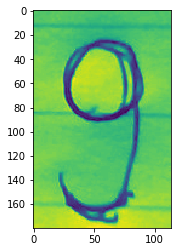

In [16]:
import cv2
import numpy as np
#from PIL import Image

im = cv2.imread('digit.jpeg')
im_bw = rgb2gray(im)

plt.imshow(im_bw)

In [20]:
im_bw.shape

(180, 114)

# Reshape the image

img_resized.shape:  (28, 28)


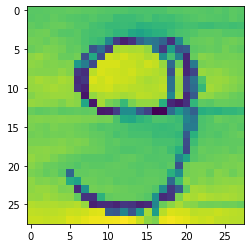

In [21]:
img_resized = cv2.resize(im_bw, (28,28))

print("img_resized.shape: ",img_resized.shape)
plt.imshow(img_resized)

# Normalize

In [27]:
img_resized /= 255.

# Load the model

In [22]:
from keras.models import load_model

model = load_model("small_model.h5")


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 8)         296       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                3930      
Total para

# Reshape the image for prediction

In [28]:
# for MLP
#img_usable = np.reshape(img_resized, (1,28*28))
# for conv
img_usable = np.reshape(img_resized, (1,28,28,1))

# Remember Keras accepts 4D tensors

In [29]:
print(img_usable.shape)

(1, 28, 28, 1)


# Run prediction on image

In [30]:
pred_prim = model.predict(img_usable)
digit = np.argmax(pred_prim)
print("digit: ",digit)

digit:  8


# Load the model in Pytorch

In [ ]:
import torch
import torchvision.models as models
from torchsummary import summary
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
PATH = 'pytorch_model2.pt'
num_classes = 10

In [ ]:
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0
        
        self.linear_1 = torch.nn.Linear(7*7*8, num_classes)

        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        logits = self.linear_1(out.view(-1, 7*7*8))
        probas = F.softmax(logits, dim=1)
        return logits, probas
torch.manual_seed(1)
model = ConvNet(num_classes=num_classes)

# Load the model

In [ ]:
model = torch.load(PATH)

In [ ]:
summary(model, (1, 28, 28))

# Read the image

In [ ]:
im = misc.imread('digit.jpeg')
im_bw = rgb2gray(im)

plt.imshow(im_bw)

# Reshape to 28x28

In [ ]:
img_resized = misc.imresize(im_bw, (28,28))

print("img_resized.shape: ",img_resized.shape)

In [ ]:
img_usable = np.reshape(img_resized, (1,1,28,28))

In [ ]:
img_usable.shape

In [ ]:
img_float = img_usable.astype('float32')

In [ ]:
img_norm = img_float / 255.

In [ ]:
img_torch = torch.from_numpy(img_norm)

In [ ]:
logits, probas = model(img_torch)
print(probas)

In [ ]:
predicted_labels = torch.max(probas,1)
print(predicted_labels)